# Formalize and Save Data

Read essays, depression and anxiety from different files and concatenate them into a dictionary containing all info needed for further exploration.

In [1]:
# !pip install gensim scikit-plot nltk keras tqdm
#############################################
%matplotlib inline
import pandas as pd
import numpy as np
import os
import pickle
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

import gensim
import re, collections
import string
import scikitplot.plotters as skplt

import nltk
from nltk.corpus import stopwords

from xgboost import XGBClassifier
import xgboost as xgb

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from tqdm import tqdm

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def words(text):
    return re.findall('[a-z]+', text.lower())
def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

NWORDS = train(words(open('big.txt').read()))
alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [a + b[1:] for a, b in splits if b]
    transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
    replaces = [a + c + b[1:] for a, b in splits for c in alphabet if b]
    inserts = [a + c + b for a, b in splits for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words):
    return set(w for w in words if w in NWORDS)

def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return max(candidates, key=NWORDS.get)

In [4]:
def modifyText(text):
    sw = set(stopwords.words('english'))
    text = re.sub(r'\[[a-zA-Z ]+\]|\r\n', '', text)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub('', text)
    mod = ''
    counter = 0
    words_count = 0
    for word in text.split(' '):
        new_word = correct(word.lower())
        if new_word not in sw:
            mod += new_word + ' '
            words_count += 1
            if(new_word != word.lower()):
                counter += 1
    return mod, counter, words_count

In [5]:
def processFile(filename):
    global data
    f = open(filename)
    with open(filename, 'rb') as f:
        texts = []
        for line in f:
            texts.append(line.decode(errors='ignore'))
        text = reduce(lambda x, y : x + y , texts[2:])
        words = filename.split("-")
        key = words[-1].split(".")[0].upper()
        data[key] = dict({"essay": text})

In [8]:
#############################################
def getData(data_filename, preprocess=True):
    global data
    global counters
    global words_counts
    if os.path.exists(data_filename):
        with open(data_filename, 'rb') as fp:
            data = pickle.load(fp)
    else:
        directory = "./essays/rtf/"
        counter = 0
        for filename in os.listdir(directory):
            if filename.endswith(".rtf"):
                processFile(directory + filename)
                counter += 1
        print("There are {0} essays.".format(counter))
        f = open("./277labels/labels.csv")
        complete_entries_list = []
        for line in f:
            entries = line.split(",")
            key = entries[0]
            depression = entries[1]
            anxiety = entries[2]
            if(key == "ncdsid" or depression == "$null$" or anxiety == "$null$"):
                continue
            else:
                depression = float(depression)
                anxiety = float(anxiety)
                if(key not in data or depression == -1.0 or anxiety == -1.0):
                    if key in data:
                        deleted = data.pop(key)
                    continue
                else:
                    data[key]["anxiety"] = anxiety
                    data[key]["depression"] = depression
                    counter += 1
                    complete_entries_list.append(key)
        print("There are {0} entries that have complete info.".format(len(complete_entries_list)))
        selected = dict({})
        for key in complete_entries_list:
            selected[key] = data[key]
            selected[key]["essay"] = re.sub(r'[0-9]+[a-zA-Zx*]*\s|words ', '', selected[key]["essay"])
        if preprocess:
            for i in tqdm(range(len(complete_entries_list))):
                key = complete_entries_list[i]
                selected[key]['essay'], counter, words_count = modifyText(selected[key]['essay'])
                counters.append(counter)
                words_counts.append(words_count)
        with open(data_filename, 'wb') as fp:
            pickle.dump(selected, fp, protocol=2)
        data = selected
    return data, counters, words_counts

In [9]:
#############################################
data = dict({})
counters = []
words_counts = []
data, counters, words_counts = getData('data_modified_count.p')

There are 10511 essays.
There are 9455 entries that have complete info.


100%|██████████| 9455/9455 [44:06<00:00,  3.57it/s]


In [29]:
data = dict({})
counters1 = []
words_counts1 = []
data, counters1, words_counts1 = getData('data_modified.p')

In [13]:
with open('data_embedding_google.p', 'rb') as fp:
    data = pickle.load(fp)

In [16]:
fea_wrong_words = counters

In [17]:
from sklearn.preprocessing import scale
fea_wrong_words = scale(fea_wrong_words)

In [22]:
fea_wrong_ratio = [x/y for (x,y) in zip(counters, words_counts)] 

In [24]:
fea_wrong_words = np.array(fea_wrong_words).reshape(9455, 1)
fea_wrong_ratio = np.array(fea_wrong_ratio).reshape(9455, 1)

In [26]:
data = np.hstack((data, fea_wrong_words, fea_wrong_ratio))

In [27]:
data.shape

(9455, 302)

In [28]:
with open('data_mod_contain_corrections.p', 'wb') as fp:
    pickle.dump(data, fp, protocol=2)

Data are stored in a dictionary named as `data`. The UCDSId is used to serve as the key of this dictionary, and the value is the detailed info encapsulated in a dictionary containing __essay__, __depression__, and __anxiety__.

In [29]:
# save data to pickle file
with open('data_modified.p', 'wb') as fp:
    pickle.dump(data, fp, protocol=2)

In [30]:
#############################################
df = pd.DataFrame.from_dict(data, orient='index')
df = df.dropna()

In [ ]:
#############################################
# compute Word2Vec using Google pre-trained model
X = df['essay']
w2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(X)

with open('data_embedding_google.p', 'wb') as fp:
    pickle.dump(mean_embedded, fp, protocol=2)
    
# 生成的文档是data_embedding_google.p

In [31]:
with open('data_mod_contain_corrections.p', 'rb') as fp:
    data = pickle.load(fp)

In [32]:
data.shape

(9455, 302)

In [33]:
# with open('data_embedding_google.p', 'rb') as fp:
#     data = pickle.load(fp)
threshold = 0
X_train, X_test, y_train, y_test = train_test_split(data, df['depression'], test_size = 0.2, random_state=49)
y_test = [1 if x > threshold else 0 for x in y_test.values.tolist()]
y_train = [1 if x > threshold else 0 for x in y_train.values.tolist()]

In [6]:
threshold = 0
X_train, X_test, y_train, y_test = train_test_split(df['essay'], df['depression'], test_size = 0.2, random_state=49)
y_test = [1 if x > threshold else 0 for x in y_test.values.tolist()]
y_train = [1 if x > threshold else 0 for x in y_train.values.tolist()]
# y_train = [int(x) for x in y_train.values.tolist()]

# Natural Language Processing

## Bag of Words

In [25]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

In [26]:
bag_of_words = count_vectorizer.fit_transform(df['essay'])
print("There are {0} unique words in corpus.".format(len(count_vectorizer.get_feature_names())))

There are 21825 unique words in corpus.


In [27]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

## Word2Vec

### Word2Vec implementation

In [1]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec  
    Args:
        sentences: iterator for sentences    
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=500, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

Train Word2Vec model and save to local disk, named as `w2vmodel`.

In [86]:
w2vec = get_word2vec(MySentences(X_train.values, X_test.values),
                     'w2vmodel_modified_delete_numbers_500')

Found w2vmodel_modified_delete_numbers_500


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin.gz', binary=True)

Having a word2vec model, we then use it to transform each documents into a feature vector. In order to convert a document of multiple words into a single vector using trained word2vec, we take the word2vec of all words in the document, then take its mean.

In [87]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

Transform training data to `mean_embedded`.

In [88]:
w2vec = model
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(X_train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [89]:
test_embedded = mean_embedding_vectorizer.fit_transform(X_test)

In [58]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [113]:
from sklearn.metrics.pairwise import cosine_similarity
# cos = cosine_similarity(mean_embedded)

In [15]:
origin = mean_embedding_vectorizer.fit_transform(df['essay'])
label = [1 if x > 0 else 0 for x in df['depression'].values.tolist()]
cos = cosine_similarity(origin)
thres = 0.96

pairs = []
for i in tqdm(range(len(cos))):
    for j in range(i, len(cos[0])):
        if cos[i][j] > thres and i != j and label[i] != label[j]:
            pairs.append((i,j))
while(len(pairs) != 0):
    print("new round ...")
    for p in pairs:
        voters = [x for x in p]
        ones = 0
        for k,sim in enumerate(cos[p[0]]):
            if sim > thres:
                voters.append(k)
                ones += label[k]
        for k,sim in enumerate(cos[p[1]]):
            if sim > thres:
                voters.append(k)
                ones += label[k]
        new_label = 1 if ones/len(voters) > 0.5 else 0
        for voter in voters:
            label[voter] = new_label
    pairs = []
    for i in tqdm(range(len(cos))):
        for j in range(i, len(cos[0])):
            if cos[i][j] > thres and i != j and label[i] != label[j]:
                pairs.append((i,j))

100%|██████████| 9455/9455 [00:18<00:00, 517.87it/s]


new round ...


  0%|          | 25/9455 [00:00<00:37, 249.74it/s]

new round ...


100%|██████████| 9455/9455 [00:18<00:00, 520.64it/s]


In [17]:
ori_label = [1 if x > 0 else 0 for x in df['depression'].values.tolist()]

In [18]:
a = [0 if x==y else 1 for (x,y) in zip(label, ori_label)]

In [19]:
sum(a)

1040

In [113]:
with open('label_mod.p', 'wb') as fp:
    pickle.dump(label, fp, protocol=2)

In [21]:
sum(label)

3009

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['essay'], label, test_size = 0.2, random_state = 49)

In [100]:
X_train[4274]

'electric elder work place put steel big ocean liners tug boats put big tunnels liners fellow mass work groups fifty men started place know twenty men father boss canteen men cooks work beside father year months weeks day steady pay xxxxweek thursday nights work past nine clock work eight till five night peace time father pals go club ord bar come back little rest start work peace dinner time time go home get dinner get wash man goes work put clean clothes shave watch tellythe next day saturday get dayoff go kitchen breakfast go place see ran '

In [111]:
data.shape

(9455, 302)

In [181]:
# origin = mean_embedding_vectorizer.fit_transform(df['essay'])
origin = data
y_train = df['depression'].values.tolist()
cos = cosine_similarity(origin)
counter = np.array([0] * 400).reshape(20, 20)
index_to_delete = set([])
for i in range(len(cos)):
    for j in range(i, len(cos[0])):
        if cos[i][j] > 0.95 and i != j and y_train[i] != y_train[j]:
#             print(i,j, y_train[i], y_train[j])
            counter[int(max(y_train[i], y_train[j]))][int(min(y_train[i], y_train[j]))] += 1
            index_to_delete.add(i)
            index_to_delete.add(j)

In [204]:
for i in counter:
    print("{0:5d}\t{1:5d}\t{2:5d}\t{3:5d}\t{4:5d}\t{5:5d}\t{6:5d}\t{7:5d}\t{8:5d}\t{9:5d}".format(i[0], i[1], i[2],\
                                                                                                     i[3],i[4],i[5],\
                                                                                                     i[6],i[7],i[8],i[9]))

    0	    0	    0	    0	    0	    0	    0	    0	    0	    0
52472	    0	    0	    0	    0	    0	    0	    0	    0	    0
31297	12631	    0	    0	    0	    0	    0	    0	    0	    0
22927	 9546	 5873	    0	    0	    0	    0	    0	    0	    0
11511	 4830	 2929	 2274	    0	    0	    0	    0	    0	    0
 5004	 2019	 1243	  941	  487	    0	    0	    0	    0	    0
 2659	 1117	  697	  541	  289	  121	    0	    0	    0	    0
 2786	 1201	  730	  569	  292	  115	   70	    0	    0	    0
  521	  216	  131	   97	   48	   22	   13	   13	    0	    0
  633	  268	  159	  120	   63	   25	   16	   17	    3	    0
    0	    0	    0	    0	    0	    0	    0	    0	    0	    0
    0	    0	    0	    0	    0	    0	    0	    0	    0	    0
    0	    0	    0	    0	    0	    0	    0	    0	    0	    0
    0	    0	    0	    0	    0	    0	    0	    0	    0	    0
    0	    0	    0	    0	    0	    0	    0	    0	    0	    0
    0	    0	    0	    0	    0	    0	    0	    0	    0	    0
    0	    0	    0	    0	    0	    0	    

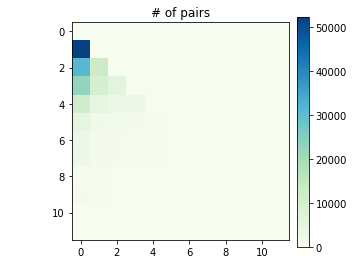

In [182]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('# of pairs')
plt.imshow(counter[:12,:12], cmap="GnBu")
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0.3)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [183]:
len(index_to_delete)

2694

In [184]:
ori_label = df['depression'].values.tolist()
filtered_label = [ori_label[i] if (i not in index_to_delete) else -1 for i in range(len(ori_label))]

In [170]:
filtered_data = []
for i in range(len(data)):
    if(i not in index_to_delete):
        filtered_data.append(data[i])
filtered_data = np.array(filtered_data)
filtered_data.shape

(6761, 302)

In [171]:
ori_label = df['depression'].values.tolist()
filtered_label = [ori_label[i] for i in range(len(ori_label)) if i not in index_to_delete]

In [186]:
len(filtered_label)

9455

In [185]:

threshold = 0
X_train, X_test, y_train, y_test = train_test_split(data, filtered_label, test_size = 0.2, random_state=49)
y_test = [1 if x > threshold else x for x in y_test]
y_train = [1 if x > threshold else x for x in y_train]

### Training models

#### Random Forest

In [187]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1, class_weight='balanced')

In [188]:
clf = clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.5min finished


In [189]:
pred = clf.predict(X_test)

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished


In [190]:
clf.n_classes_

3

In [191]:
a = [ x==y for (x,y) in zip(pred.tolist(), y_test)]

In [192]:
sum(a)/len(a)

0.6398730830248546

In [193]:
clf.score(X_train, y_train)

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.9s finished


0.9976203067160233

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


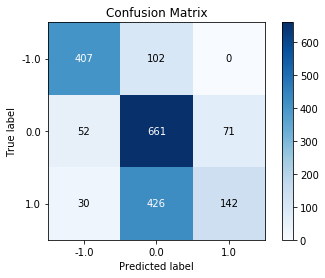

In [197]:
probas = clf.predict_proba(X_test).tolist()
pred_indices = np.argmax(probas, axis=1)
# classes = np.array(range(clf.n_classes_))
classes = np.array([-1,0,1])
preds = classes[pred_indices]
# true_labels = [int(x+1) for x in y_test]
# print('Log loss: {}'.format(log_loss(classes[y_test], probas)))
# print('Accuracy: {}'.format(accuracy_score(classes[y_test], preds)))
skplt.plot_confusion_matrix(y_test, preds)
# skplt.plot_confusion_matrix(true_labels, preds)
probas = clf.predict_proba(X_test)

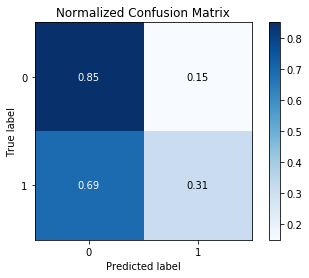

In [89]:
skplt.plot_confusion_matrix(classes[y_test], preds, normalize=True)

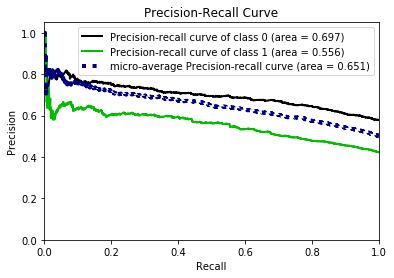

In [90]:
import scikitplot
scikitplot.metrics.plot_precision_recall(y_test, probas)

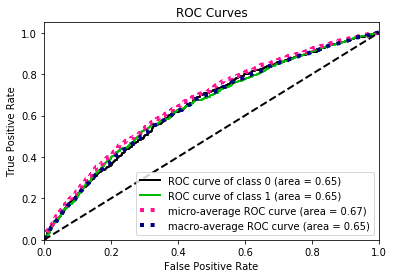

In [91]:
scikitplot.metrics.plot_roc(y_test, probas)

#### XGBoost

In [44]:
def xgboost_plst():
    param = {}
    param['max_depth']= 2   # depth of tree
    param['eta'] = 0.3      # shrinkage parameter
    param['silent'] = 1     # not silent
    param['objective'] = 'binary:logistic'
    param['nthread'] = 7 # Number of threads used
    param['eval_metric'] = 'logloss'

    plst = param.items()
    return plst

In [99]:
mean_embedded = X_train
test_embedded = X_test
dtrain = xgb.DMatrix(mean_embedded, label=np.array(y_train))
dtest = xgb.DMatrix(test_embedded, label=np.array(y_test))
booster = xgb.train(xgboost_plst(), dtrain, 400)
pred = booster.predict(dtest, output_margin=False, ntree_limit=booster.best_ntree_limit)

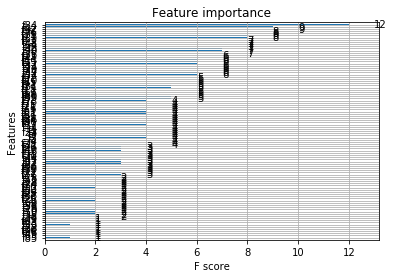

In [179]:
xgb.plot_importance(booster)

In [46]:
a = [(x - 0.5)*(y-0.5) > 0 for (x, y) in zip(pred.tolist(), y_test)]

In [47]:
sum(a)/len(a)

0.6012691697514543

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


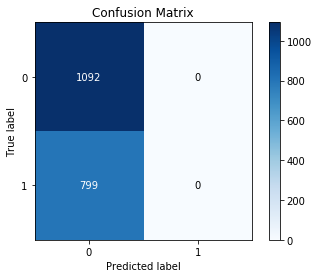

In [48]:
pred_indices = [1 if x < 0 else 0 for x in pred]
# print('Log loss: {}'.format(log_loss(classes[y_test], pred)))
# print('Accuracy: {}'.format(accuracy_score(classes[y_test], preds)))
skplt.plot_confusion_matrix(y_test, pred_indices)

#### Adaboost

0.6017979904812268
Log loss: 1.0607553520541328
Accuracy: 0.6017979904812268


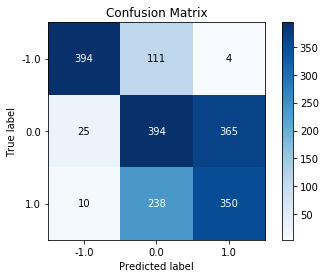

In [198]:
mean_embedded = X_train
test_embedded = X_test
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, class_weight='balanced'), algorithm="SAMME.R", n_estimators=1000)
clf = clf.fit(mean_embedded, y_train)
pred = clf.predict(test_embedded)
a = [ x==y for (x,y) in zip(pred.tolist(), y_test)]
print(sum(a)/len(a))
probas = clf.predict_proba(test_embedded).tolist()
pred_indices = np.argmax(probas, axis=1)
# classes = np.array(range(0, 2))
classes = np.array([-1,0,1])
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(y_test, probas)))
print('Accuracy: {}'.format(accuracy_score(y_test, preds)))
skplt.plot_confusion_matrix(y_test, preds)
# print('Log loss: {}'.format(log_loss(classes[y_test], probas)))
# print('Accuracy: {}'.format(accuracy_score(classes[y_test], preds)))
# skplt.plot_confusion_matrix(classes[y_test], preds)

In [78]:
clf.score(mean_embedded, y_train)

1.0

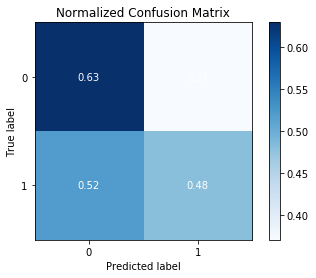

In [101]:
skplt.plot_confusion_matrix(classes[y_test], preds, normalize=True)

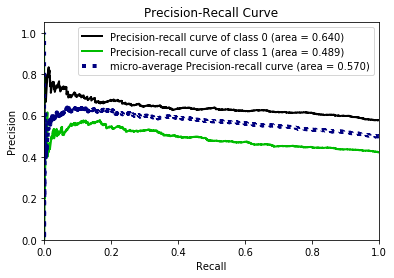

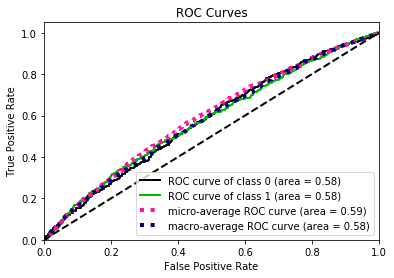

In [102]:
scikitplot.metrics.plot_precision_recall(y_test, probas)
scikitplot.metrics.plot_roc(y_test, probas)

#### Neural Network

In [48]:
!cat nn_config.yaml 

## Training data file path
training_data_path: ./Data/higgs_train_small.csv

## Testing data file path
test_data_path: ./Data/higgs_test_small.csv 

## Location in which you will save the pickle file containing predictions on test data
output_predictions_pickle_path: ./Data/test_predictions.pkl

## Location in which the ground truth test labels are stored
gt_test_labels: ./Data/ground_truth_test_labels_small.pkl

## How to split the input training data into train and validation sets. Value of 0.8 means that if there were initially 100 training examples in the input data, you should split them such that the first 80 are used as training examples and last 20 should be used for validation.
training_to_validation_ratio: 0.8

## the learning rate you should use for your optimizer 
learning_rate: 0.05

## the total number of epochs or iterations to run over the (80) training examples
epochs: 200

## the number of mini batches in which you should split your (80) training examples. Continuing 

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
import tensorflow as tf
from matplotlib import pyplot as plt

## Pretty Print
import pprint as pp

In [51]:
import yaml
def import_config():
    with open("nn_config.yaml", 'r') as ymlfile:
        try:
            cfg = yaml.load(ymlfile)
        except yaml.YAMLError as err:
            print(err)
    return cfg

In [52]:
cfg = import_config()

## Is it loaded correctly?
pp.pprint(cfg)

{'dataset_size': 'small',
 'display_step': 5,
 'epochs': 200,
 'gt_test_labels': './Data/ground_truth_test_labels_small.pkl',
 'hidden_layer_sizes': {'first_layer': 20, 'second_layer': 8},
 'learning_rate': 0.05,
 'num_mini_batches': 10,
 'output_predictions_pickle_path': './Data/test_predictions.pkl',
 'test_data_path': './Data/higgs_test_small.csv',
 'training_data_path': './Data/higgs_train_small.csv',
 'training_to_validation_ratio': 0.8}


In [53]:
def standardize(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu)/sigma

In [235]:
training_data = mean_embedded

In [274]:
learning_rate = cfg['learning_rate']
training_epochs = cfg['epochs'] * 10
train_valid_split = cfg['training_to_validation_ratio']
num_batches = cfg['num_mini_batches']
display_step = cfg['display_step'] * 10

num_examples= training_data.shape[0]

# The first `num_train_examples` should be used for training, the rest for validation.
num_train_examples = int(num_examples * train_valid_split)

batch_size = num_train_examples/num_batches


# Network Parameters
n_hidden_1 = cfg['hidden_layer_sizes']['first_layer']*3 # 1st layer number of features
n_hidden_2 = cfg['hidden_layer_sizes']['second_layer']*3 # 2nd layer number of features
n_input = 302 
n_classes = 3 


print("Total Training examples: %d, Number of Batches: %d, Batch Size: %d" %(num_train_examples,num_batches,batch_size))

Total Training examples: 6051, Number of Batches: 10, Batch Size: 605


In [275]:
# TF Graph input
## Use the below placeholders appropriately inside the train_nn() function

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, 3])
n_hidden_3 = 5

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [276]:
def create_feedforward_nn_model(x, weights, biases):
    # Hidden layer with SIGMOID activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    layer_1 = tf.nn.dropout(layer_1, 0.5)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    layer_2 = tf.nn.dropout(layer_2, 0.5)
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)
    out_layer = tf.add(tf.matmul(layer_3, weights['out']), biases['out'])
    return out_layer

In [277]:
# Construct model
def stitch_network(x, y, weights, biases, learning_rate):
    
    pred_raw = create_feedforward_nn_model(x, weights, biases)
    pred = tf.round(tf.nn.sigmoid(pred_raw))
    probas = tf.nn.sigmoid(pred_raw)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred_raw, labels=y))
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    return pred_raw, pred, loss, train_op, probas


pred_raw, pred, loss, train_op, probas = stitch_network(x, y, weights, biases, learning_rate)

In [278]:
init = tf.global_variables_initializer()

In [279]:
def train_nn():
    with tf.Session() as sess:

        sess.run(init)
        
        ## this is needed to print debug statements during training.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        x_train, x_valid = features[:num_train_examples], features[num_train_examples:]
        y_train, y_valid = labels[:num_train_examples], labels[num_train_examples:]

        y_valid = y_valid.reshape(len(y_valid), 1)
        y_valid = np.array([[0, 0, 1] if x == -1 else ([0, 1, 0] if x == 0 else [1, 0, 0]) for x in y_valid])
        training_losses = []
        training_accs = []

        validation_losses = []
        validation_accs = []
        
        
        for epoch in range(training_epochs):
            loss_counter = 0
            correct_counter = 0
            for num_batch in range(num_batches):
                cur_features = x_train[int(num_batch * batch_size) : int(min(len(x_train), (num_batch + 1) * batch_size))]
                cur_labels = y_train[int(num_batch * batch_size) : int(min(len(x_train), (num_batch + 1) * batch_size))]
                cur_labels = cur_labels.reshape(len(cur_labels), 1)
                cur_labels = np.array([[0, 0, 1] if x == -1 else ([0, 1, 0] if x == 0 else [1, 0, 0]) for x in cur_labels])
                _, cur_loss, cur_pred = sess.run([train_op, loss, pred], feed_dict={x:cur_features, y:cur_labels})
                loss_counter += cur_loss * len(cur_labels)
#                 correct_counter += sum([1 if x==y else 0 for (x,y) in zip(cur_labels, cur_pred)])
#             training_losses.append(np.float64(loss_counter/len(x_train)))
#             training_accs.append(np.float64(correct_counter/len(x_train)))
            
            _, val_loss, val_pred = sess.run([train_op, loss, pred], feed_dict={x: x_valid, y: y_valid})
            validation_losses.append(np.float64(val_loss))
#             validation_accs.append(np.float64(sum([1 if x==y else 0 for (x,y) in zip(y_valid, val_pred)])/len(y_valid)))
        
#             if epoch%display_step==0:
#                     print("Epoch {0} | Tr loss: {1} | Tr accuracy {2} | Va loss: {3} | Va accuracy: {4}"\
#                           .format(epoch + 1,training_losses[epoch],training_accs[epoch],validation_losses[epoch], validation_accs[epoch]))       
#         print("Optimization Finished!")

        test_predictions = []
#         test_label = np.array[0] * len(test_features)
#         test_label = test_label
        test_pred, proba = sess.run([pred, probas], feed_dict={x: test_features})
        test_predictions = np.float64(test_pred.T[0]) 
        
        ## this is needed to print debug statements during training.
        coord.request_stop()
        coord.join(threads)
    
    ## close TF session if open
    if 'session' in locals() and sess is not None:
        print('Close interactive session')
        sess.close()
        
    return training_losses, validation_losses, training_accs, validation_accs, test_predictions, proba

In [280]:
# features = mean_embedded
# labels = np.array(y_train)
features = X_train
labels = np.array(y_train)
test_features = X_test
# test_features = test_embedded
training_losses, validation_losses, training_accs, validation_accs, test_predictions, probas = train_nn()

In [262]:
np.array([[0, 0, 1] if x == -1 else ([0, 1, 0] if x == 0 else [1, 0, 0]) for x in y_train])

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [264]:
X_test

array([[ 2.27871593e-02,  6.77114651e-02,  5.01119671e-03, ...,
        -3.35369110e-02,  2.20954519e+00,  1.98473282e-01],
       [ 2.86758207e-02,  5.76537065e-02,  9.68414592e-04, ...,
         6.18825387e-03, -1.13830750e-01,  8.41121495e-02],
       [ 4.02552076e-02,  4.42559645e-02,  1.33529790e-02, ...,
        -1.11250719e-02, -5.23838269e-01,  4.72440945e-02],
       ...,
       [ 4.48217019e-02,  7.46455938e-02,  1.37638813e-02, ...,
        -5.20718545e-02, -3.87169096e-01,  3.72340426e-02],
       [ 2.73261368e-02,  6.02077916e-02,  3.35738584e-02, ...,
        -3.89851704e-02, -3.87169096e-01,  8.53658537e-02],
       [-7.18688965e-03,  6.32413998e-02,  3.95512283e-02, ...,
        -2.26064567e-02,  7.06184289e-01,  2.02702703e-01]])

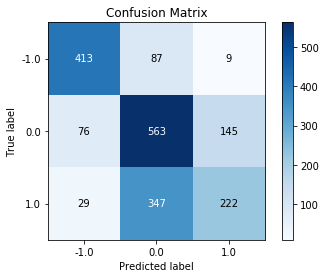

In [282]:
classes = np.array([1,0,-1])
test_predictions = classes[np.argmax(probas, axis = 1)]
skplt.plot_confusion_matrix(y_test, test_predictions)

In [284]:
a = [x == y for (x,y) in zip(y_test, test_predictions)]

In [285]:
sum(a)/len(a)

0.6335272342675833

In [272]:
test_predictions[:10]

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [63]:
probas = [[x, 1-x] for x in probas]

In [64]:
probas = [[x[0][0], x[1][0]] for x in probas]

In [65]:
probas = np.array(probas)

In [66]:
probas = probas.tolist()

In [67]:
probas = [[x[1], x[0]] for x in probas]

In [68]:
def plot_loss_vs_epochs(training_losses, validation_losses):
    plt.title("loss vs epochs")
    plt.plot(training_losses)
    plt.plot(validation_losses)
    plt.legend(["training","validation"])

In [69]:
def plot_acc_vs_epochs(training_acc, validation_acc):
    plt.title("accuracy vs epochs")
    plt.plot(training_acc)
    plt.plot(validation_acc)
    plt.legend(["training","validation"])

In [70]:
def plots(training_losses, validation_losses, training_accs, validation_accs):
    
    fig = plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    plot_loss_vs_epochs(training_losses, validation_losses)
    plt.subplot(1,2,2)
    plot_acc_vs_epochs(training_accs, validation_accs)

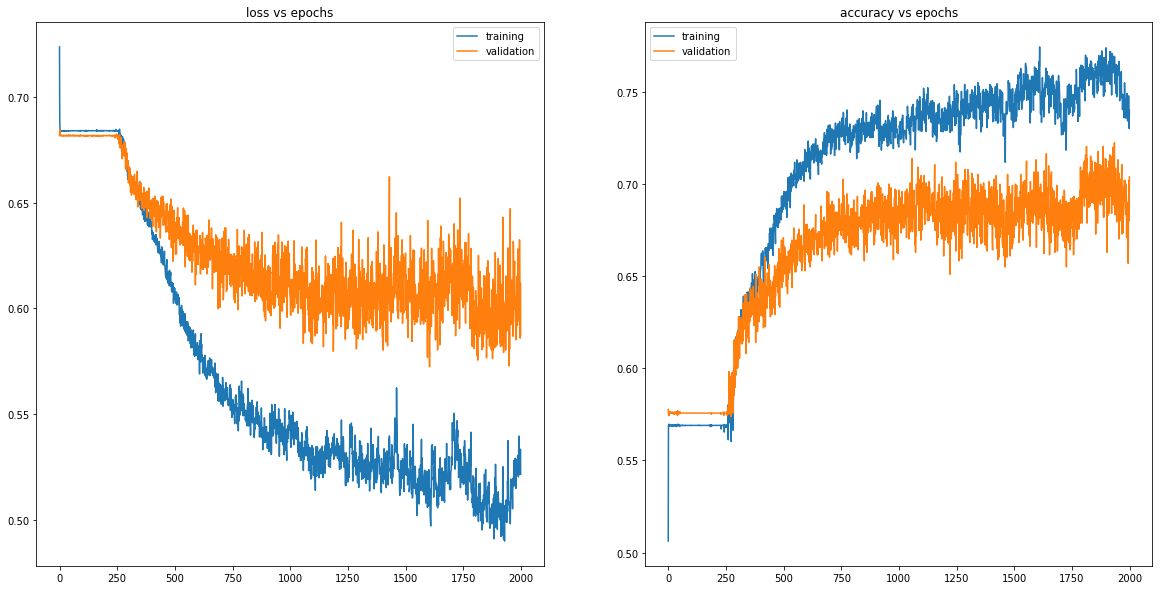

In [71]:
plots(training_losses, validation_losses, training_accs, validation_accs)

In [72]:
a = [1 if x==y else 0 for (x,y) in zip(test_predictions.tolist(), y_test)] 

In [73]:
sum(a)/len(a)

0.5875198307773665

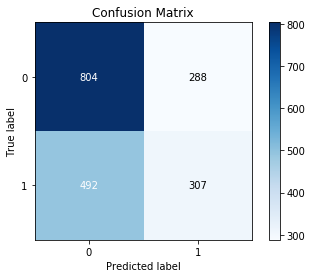

In [74]:
skplt.plot_confusion_matrix(y_test, test_predictions.tolist())

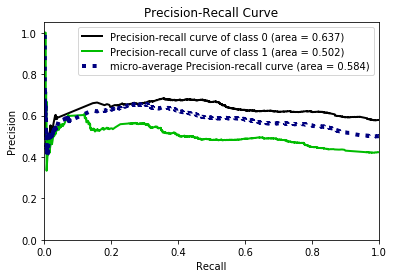

In [75]:
scikitplot.metrics.plot_precision_recall(y_test, probas)

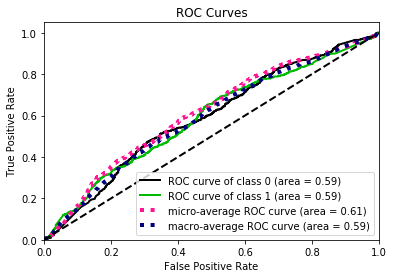

In [76]:
scikitplot.metrics.plot_roc(y_test, probas)

## LSTM

In [106]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train.values)
# Pad the data 
X = tokenizer.texts_to_sequences(X_train.values)
X = pad_sequences(X, maxlen=2000)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [107]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196
num_words = 2000
# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

NameError: name 'X' is not defined

In [25]:
# Y = np.array(y_train)
Y = to_categorical(np.array(y_train))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(6051, 2000) (6051, 2)
(1513, 2000) (1513, 2)


In [151]:
batch_size = 32
trained_model = model.fit(X_train, Y_train, epochs=3, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Train on 4840 samples, validate on 1211 samples
Epoch 1/3
4840/4840 [==============================] - 564s 117ms/step - loss: 0.5634 - categorical_crossentropy: 0.5634 - val_loss: 0.5438 - val_categorical_crossentropy: 0.5438

Epoch 00001: val_loss improved from inf to 0.54375, saving model to keras_model_mod
Epoch 2/3
4840/4840 [==============================] - 569s 118ms/step - loss: 0.5140 - categorical_crossentropy: 0.5140 - val_loss: 0.5407 - val_categorical_crossentropy: 0.5407

Epoch 00002: val_loss improved from 0.54375 to 0.54070, saving model to keras_model_mod
Epoch 3/3
4840/4840 [==============================] - 564s 117ms/step - loss: 0.4712 - categorical_crossentropy: 0.4712 - val_loss: 0.5594 - val_categorical_crossentropy: 0.5594

Epoch 00003: val_loss did not improve from 0.54070


In [26]:
trained_model = load_model('keras_model')

In [27]:
pred = trained_model.predict(X_test)

In [28]:
train_res = trained_model.predict(X_train)

In [154]:
pred

array([[0.6824952 , 0.31750488],
       [0.58279204, 0.41720793],
       [0.92767525, 0.0723248 ],
       ...,
       [0.92364746, 0.07635255],
       [0.8594198 , 0.14058013],
       [0.902439  , 0.09756105]], dtype=float32)

In [29]:
probas = train_res
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(2))
preds = classes[pred_indices]
accuracy_score(classes[np.argmax(Y_train, axis=1)], preds)

0.5713105271855892

Log loss: 0.6860036319029387
Accuracy: 0.5426305353602116


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


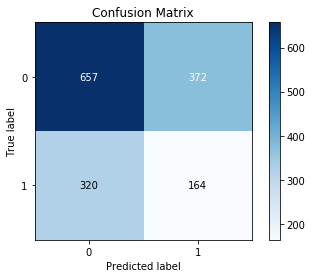

In [30]:
probas = pred
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(2))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

In [382]:
Y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

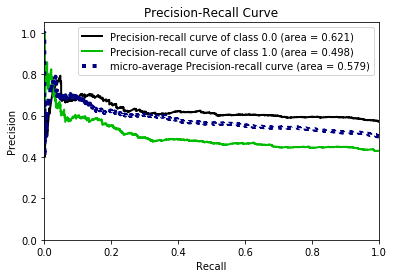

In [384]:
scikitplot.metrics.plot_precision_recall(Y_test[:,1], pred)

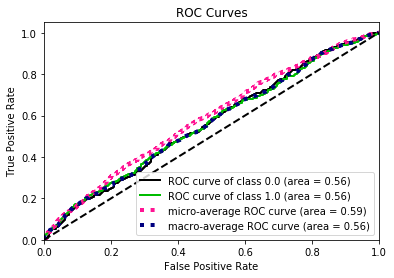

In [385]:
scikitplot.metrics.plot_roc(Y_test[:,1], pred)

# Load data from local files

In [16]:
with open('data_modified.p', 'rb') as fp:
    data = pickle.load(fp)

In [4]:
len(data)

10221

In [20]:
import numpy, scipy.io
scipy.io.savemat('data.mat', mdict=data)

In [106]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(500, 2), random_state=1)
clf = clf.fit(mean_embedded, y_train)

In [107]:
pred = clf.predict(test_embedded)
a = [ x==y for (x,y) in zip(pred.tolist(), y_test)]
sum(a)/len(a)

0.5552617662612375

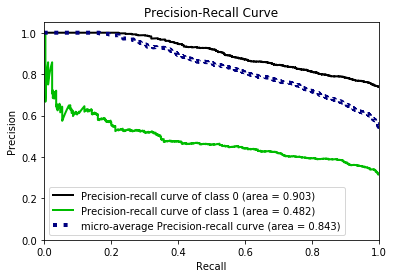

In [201]:
scikitplot.metrics.plot_precision_recall(y_test, probas)

In [108]:
import scikitplot

In [79]:

a = 263/(263+387)
b = 263/(263+279)
print(a, b, 2*a*b/(a+b))

0.4046153846153846 0.48523985239852396 0.44127516778523485
